# MCMC in PFJAX

**Martin Lysy, University of Waterloo** 

**January 27, 2022**

## Overview

PFJAX provides the following tools for MCMC sampling from the full posterior distribution $p(\xx_{0:T}, \tth \mid \yy_{0:T})$:

- `pf.particle_filter()` and `pf.particle_smooth()`: Sample from $p(\xx_{0:T} \mid \tth, \yy_{0:T})$ using a particle filter.

- `mcmc.param_mwg_update()` and `mcmc.mwg_adapt()`: Sample from $p(\tth \mid \xx_{0:T}, \yy_{0:T})$ using an adaptive Metropolis-within-Gibbs (MWG) sampler. 

## Partially Jitted Gibbs Sampler

In this case, the components of the Gibbs sampler are jitted but not the full sampler.  Jitting the full sampler (i.e. using `lax.scan()`) takes a bit more effort.  It would be interesting to compare the timings to see how much benefit this has.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import numpy as np
import pfjax as pf
import pfjax.mcmc as mcmc
from functools import partial

# jit the components of the pg sampler

@partial(jax.jit, static_argnums=(0, 4))
def state_update(model, key, y_meas, theta, n_particles):
    """
    Update the state variables.

    **FIXME:** Full docstring in same style as rest of pfjax.
    """
    key, subkey = random.split(key)
    pf_out = pf.particle_filter(model, subkey, y_meas, theta, n_particles)
    return pf.particle_smooth(key,
                              logw=pf_out["logw"][y_meas.shape[0]-1],
                              x_particles=pf_out["x_particles"],
                              ancestors=pf_out["ancestors"])

def param_update(model, prior, key, theta, x_state, y_meas, rw_adapt, n_accept, n_iter):
    """
    Update the parameters and the MWG standard deviations.
    """
    theta_order = jnp.arange(len(theta))
    key, subkey = random.split(key)
    theta_order = jnp.arange(len(theta))
    theta, accept = mcmc.param_mwg_update(model, prior, subkey, theta, x_state, y_meas, rw_adapt, theta_order)
    n_accept = n_accept + accept
    accept_rate = (1.0 * n_accept) / n_iter
    rw_adapt = mcmc.mwg_adapt(rw_adapt, accept_rate, n_iter)
    return theta, rw_adapt, n_accept

param_update = jax.jit(param_update, static_argnums=(0, 1))


def particle_gibbs_for(model, prior, key, n_iter, y_meas, theta_init, x_state_init, n_particles, rw_sd):
    """
    Sample from the joint distribution of `p(x_{0:T}, theta | y_{0:T})` using a Particle Gibbs sampler.
    
    Args:
        model: Object specifying the state-space model.
        prior: Object specifying the parameter prior.
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        y_meas: The sequence of `n_obs` measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
        theta_init: A vector of `n_params` parameter values to initialize the sampler.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements:
        - x_state: MCMC output for the state variables, with leading dimension `n_iter`.
        - theta: MCMC output for the parameters, with leading dimension `n_iter`.
        - accept_rate: Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    x_state_out = jnp.zeros((n_iter,) + x_state_init.shape)
    n_params = theta_init.size
    theta_order = jnp.arange(n_params)
    theta_out = jnp.zeros((n_iter, n_params))
    theta = theta_init
    rw_adapt = rw_sd
    n_accept = jnp.zeros(theta_init.shape)
    # run the sampler
    for i in range(n_iter):
        # perform updates
        key, *subkeys = random.split(key, num=3)
        x_state = state_update(model, subkeys[0], y_meas, theta, n_particles)
        theta, rw_adapt, n_accept = param_update(model, prior, subkeys[1], theta, x_state, y_meas, 
                                                 rw_adapt, n_accept, i)
        # store
        theta_out = theta_out.at[i].set(theta)
        x_state_out = x_state_out.at[i].set(x_state)
    return {"theta": theta_out, "x_state": x_state_out, "accept_rate": (1.0 * n_accept)/n_iter}

## Tests

- [x] Check that the code above runs without errors.

- [ ] Check MCMC posteriors for simple models (e.g., `BMModel`, `LotVolModel`) against output from a different MCMC sampler, e.g., **Turing.jl**.

In [2]:
jnp.flip(jnp.arange(10))

DeviceArray([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int32)

In [3]:
import pfjax.bm_model as bm
import pandas as pd
import seaborn as sns

/Users/michelleko/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# initial key for random numbers
key = random.PRNGKey(0)

# parameter values
mu = 5.
sigma = .2
tau = 1.
theta = np.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = bm.BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta)

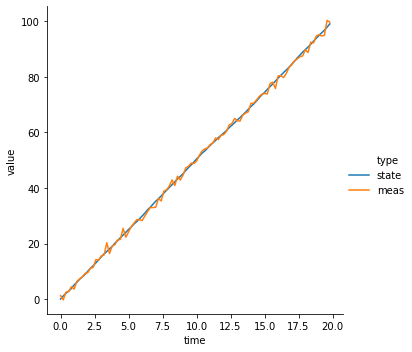

In [5]:
# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

In [6]:
# Test
prior = mcmc.FlatPrior()
n_particles = 100
rw_sd = np.array([0.01, 0.01, 0.01])
n_iter = 10000
theta_init = np.array([4.,0.1,3])
theta_order = (0,1,2)

In [7]:
# Particle Gibbs on BMM
pg_test = particle_gibbs_for(bm_model, prior, subkey, n_iter, y_meas, theta_init, x_state, n_particles, rw_sd)


In [8]:
plot_df = pd.DataFrame({"iter": np.arange(n_iter),
                         "mu": pg_test['theta'][:,0],
                         "sigma": pg_test['theta'][:,1],
                         "tau": pg_test['theta'][:,2]})

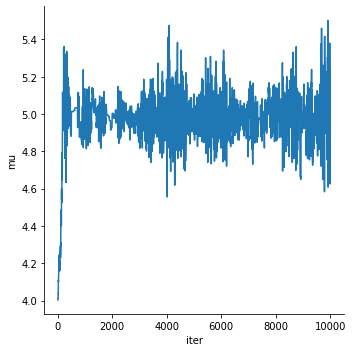

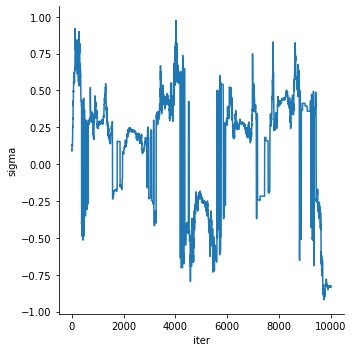

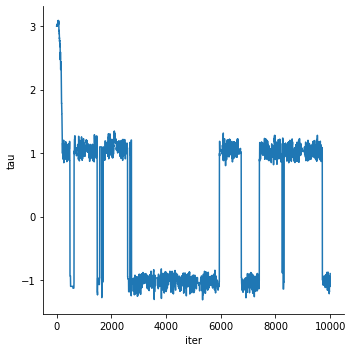

In [9]:
import matplotlib.pyplot as plt

sns.relplot(data=plot_df, kind="line",x="iter", y="mu")
sns.relplot(data=plot_df, kind="line",x="iter", y="sigma")
sns.relplot(data=plot_df, kind="line",x="iter", y="tau")
